In [11]:
import os

import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from typing import *
from datetime import datetime
from dateutil.parser import parse
import requests

## Read the CSV in

The converters thing is so 'genres' are actually a list, and not a blob of text

In [101]:
df = pd.read_csv("books.csv", converters={"genres": eval})
df = df.drop('Unnamed: 0', 1)

In [102]:
df.head()

,title,author,rating,date,genres
0,How to win friends and influence people,Dale Carnegie,2.0,2018-01-29,"[management, non-fiction, self-help]"
1,Fire and Fury,Michael Wolff,2.0,2018-01-29,"[non-fiction, politics]"
2,The Leopard,Jo Nesbo,3.0,2018-01-29,"[fiction, scandi noir]"
3,Killing & Dying,Adrian Tomine,4.0,2018-01-29,"[fiction, graphic novel]"
4,Lagom,Linea Dunne,3.0,2018-01-30,"[non-fiction, self-help]"


## Books read per year

2021 has just begun!

<AxesSubplot:xlabel='year'>

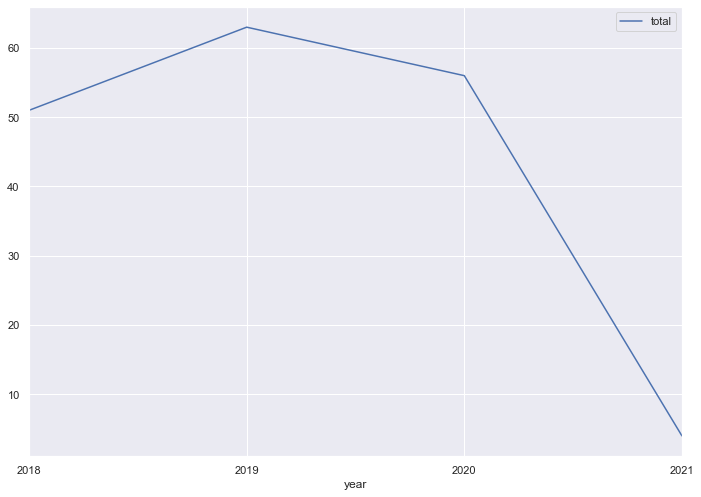

In [581]:
bpy = pd.read_csv("books_per_year.csv")
bpy.columns = ['year', 'total']
bpy.index = pd.to_datetime(bpy.year, format='%Y')
bpy = bpy.drop('year', axis=1)
bpy.plot()

## Rating Distribution
Maybe I'm too generous

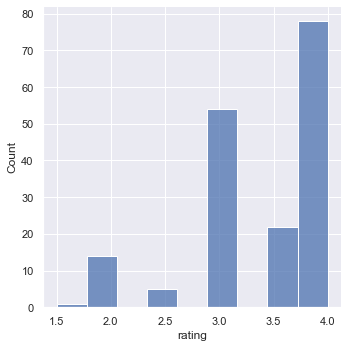

In [582]:
sns.displot(df, x="rating")

## Top 10 Most Popular Authors
This doesn't include duplicates, but I figure it still makes them popular.

In [370]:
df.groupby('author').count().sort_values('title', ascending=False).head(10).title

author
Jo Nesbo             10
JK Rowling            8
John Green            5
Andrzej Sapkowski     5
HP Lovecraft          5
Henning Mankell       4
Clive Hamilton        4
Brian Jacques         3
Meik Wiking           3
Mark Manson           3
Name: title, dtype: int64

## Ratings over time

Interestingly it would appear that as time goes by, I tend to rate books higher. 
A few hypotheses might be:
  * I'm pickier
  * I stop reading books I don't enjoy (and don't finish and catalogue them)
  
Also looks like as the year drags on, I start reading less enjoyable things!

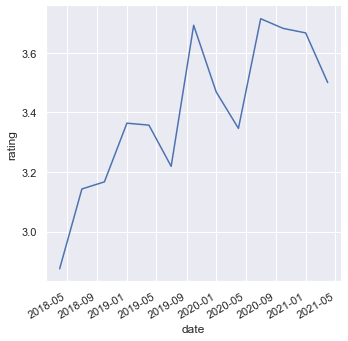

In [583]:
df_ratings = df.set_index('date')
df_ratings.index = pd.to_datetime(df_ratings.index)
df_ratings = df_ratings.resample('1Q').mean()
g = sns.relplot(x='date', y='rating', data=df_ratings, kind='line')
g.fig.autofmt_xdate()

## Books read multiple times

A personal unspoken sort-of rule is not to read the same book twice in year, but it's ok once a new year has rolled over.

What's interesting here is:
  * Ratings changing after a re-read
  * Majority of them are rated quite high, which would explain the re-read at all

In [403]:
df_dups = df.set_index('date')
df_dups[df_dups.duplicated(['title'], keep=False)].sort_values(['title', 'date', 'rating'])

,title,author,rating,genres
date,,,,
2018-10-01,A Higher Loyalty,James Comey,4.0,"['biographical', 'non-fiction', 'politics']"
2019-05-16,A Higher Loyalty,James Comey,4.0,"['biographical', 'non-fiction', 'politics']"
2018-09-09,Affluenza,Clive Hamilton,3.0,"['finance', 'non-fiction', 'politics']"
2019-12-20,Affluenza,Clive Hamilton,3.5,"['finance', 'non-fiction', 'politics']"
2018-07-26,Believe Me,Eddie Izzard,4.0,"['biographical', 'non-fiction']"
2019-01-22,Believe Me,Eddie Izzard,3.0,"['biographical', 'non-fiction']"
2018-07-29,Bullshit Jobs,David Graeber,4.0,"['business', 'non-fiction']"
2020-05-31,Bullshit Jobs,David Graeber,3.5,"['business', 'non-fiction']"
2018-01-29,Killing & Dying,Adrian Tomine,4.0,"['fiction', 'graphic novel']"


## Fiction vs Non-fiction
Each book is tagged with one or more genres, and always has at least fiction or non-fiction

In [436]:
from collections import Counter
fnf = Counter([i for l in df.genres.tolist() for i in l if i in ("non-fiction", "fiction")])
nf = fnf["non-fiction"]
f = fnf["fiction"]

In [441]:
print(f"Percentage non-fiction: {round(nf / (f + nf) * 100)}%")

Percentage non-fiction: 56%


In [442]:
print(f"Percentage fiction: {round(f / (f + nf) * 100)}%")

Percentage fiction: 44%


## Fiction vs Non-fiction over time

Does the occurrence change much over the last few years?

In [151]:
gdf = df.explode("genres").drop(["title", "author", "rating"], axis=1)
gdf = gdf[gdf.genres.isin(['fiction', 'non-fiction'])]
gdf = gdf.set_index('date', drop=False)
gdf.index = pd.to_datetime(gdf.index)
gdf = gdf.groupby([pd.Grouper(freq='M'), 'genres']).count()

gdf.index = gdf.index.rename(['month', 'genres'])
gdf = gdf.reset_index().set_index("month")
gdf.columns = ['genres', 'count']

fig = px.line(gdf, x=gdf.index, y="count", color="genres", title='Fiction vs Non-fiction over time')
fig.show()

## Top 10 Genres

In [443]:
genre_counts = Counter([i for l in df.genres.tolist() for i in l if i not in ("non-fiction", "fiction")])

In [445]:
genre_counts.most_common(10)

[('fantasy', 29),
 ('self-help', 28),
 ('biographical', 18),
 ('management', 16),
 ('scandi noir', 15),
 ('programming', 14),
 ('politics', 13),
 ('technology', 13),
 ('classic', 12),
 ('business', 12)]